In [1]:
import gnssmapper as gm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm


In [2]:
samples=pd.read_csv('../data/ucl_exact_samples.csv',index_col=0)
height= 46
samples_long=samples.melt(id_vars=('est_lb','est','est_ub'),var_name="metric",value_name='size')

Intersection Metrics and Window metrics have an inverse relationship

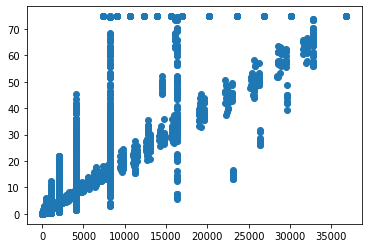

In [3]:
plt.scatter(samples.I_4,1/samples.W_100)

<AxesSubplot:>

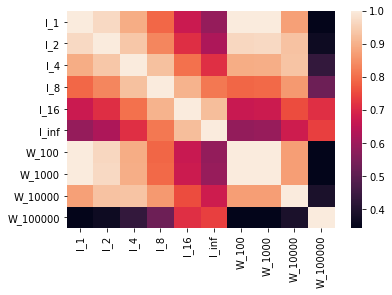

In [6]:
sns.heatmap(pd.concat((samples.iloc[:,:6],1/samples.iloc[:,6:10]),axis=1).corr())

W_100000 quite different at the data sizes we are working with, because of the level of inf observations

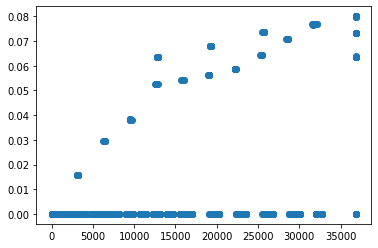

In [7]:
plt.scatter(samples.I_4,1/samples.W_100000)

In [6]:
samples_long['error']=abs(samples_long.est-height)

In [7]:
samples_long

,est_lb,est,est_ub,metric,size,error
0,44.763988,44.778988,44.793988,I_1,0.000000,1.221012
1,46.036458,46.126882,46.217306,I_1,0.000000,0.126882
2,49.919816,66.029992,82.140168,I_1,0.000000,20.029992
3,44.677146,44.942680,45.208213,I_1,0.000000,1.057320
4,29.642109,30.219266,30.796422,I_1,0.000000,15.780734
...,...,...,...,...,...,...
68995,39.645877,43.701598,47.757318,W_100000,13.052856,2.298402
68996,39.638907,43.730238,47.821568,W_100000,13.042816,2.269762
68997,39.638048,43.710375,47.782702,W_100000,13.041787,2.289625
68998,39.625307,43.709211,47.793114,W_100000,13.036680,2.290789


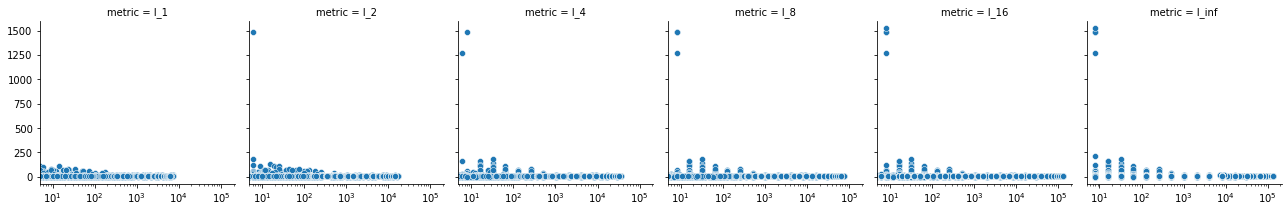

In [47]:
g=sns.FacetGrid(data=samples_long[samples_long.metric.str.startswith('I')],col='metric')
g.map_dataframe(sns.scatterplot,x="size", y="error")
plt.xscale('log')
#plt.ylim(0,20)
#plt.yscale('log')

In [173]:
from scipy import interpolate
I=samples_long[samples_long.metric.str.startswith('I')].groupby(['metric','size'], as_index=False).error.agg(lambda x: (np.sum(x**2)/len(x))**0.5)
a=[]
for _,g in I.groupby('metric'):
    b=interpolate.UnivariateSpline(g['size'], g['error'],k=3,s=2000)
    new_error=b(g['size'],nu=0)
    a.extend(new_error)
I['smooth']=a
df=[]
for _,g in samples_long[samples_long.metric.str.startswith('I')].groupby('metric'):
    o=np.unique(sm.nonparametric.lowess(g['error'].values,g['size'].values,frac=0.25),axis=0)[:,1]
    df.extend(o)
    # df=pd.DataFrame(sm.nonparametric.lowess(g['error'].values,g['size'].values,frac=0.25)).drop_duplicates()
    # df.columns=(["size",'error'])
I['lowess']=np.array(df)

In [174]:
I

,metric,size,error,smooth,lowess
0,I_1,0.0,109.042317,108.829550,5.739426
1,I_1,1.0,16.943935,18.594850,4.832031
2,I_1,2.0,94.788672,87.368272,3.974044
3,I_1,3.0,16.813956,31.216176,3.226048
4,I_1,4.0,8.776405,0.194817,2.991993
...,...,...,...,...,...
5489,I_inf,116296.0,2.283449,1.782697,2.236506
5490,I_inf,119322.0,1.857880,1.890338,2.225194
5491,I_inf,127785.0,2.320901,2.444719,2.193491
5492,I_inf,129403.0,2.270801,2.597944,2.187424


(0.0, 40.0)

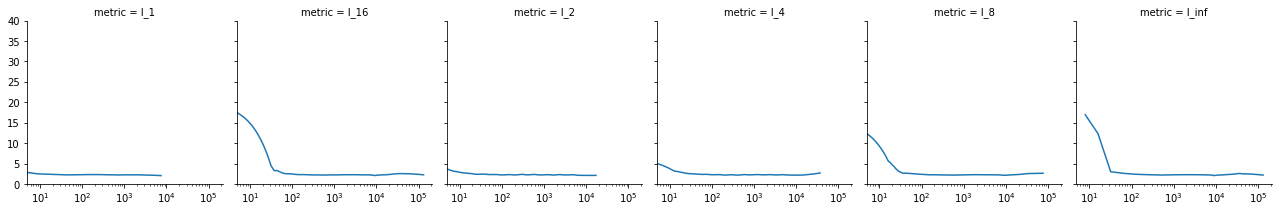

In [175]:
g=sns.FacetGrid(I,col='metric')
g.map_dataframe(sns.lineplot,x='size',y='lowess')
plt.xscale('log')
plt.ylim(0,40)

In [97]:
b=test.groupby('size').error.mean()
b

size
0.0        51.819542
1.0        10.510895
2.0         6.796776
3.0         8.934163
4.0         6.193229
             ...    
64831.0     2.296908
64868.0     2.308558
64872.0     2.290789
65536.0     2.658982
75356.0     2.472748
Name: error, Length: 915, dtype: float64

(0.0, 20.0)

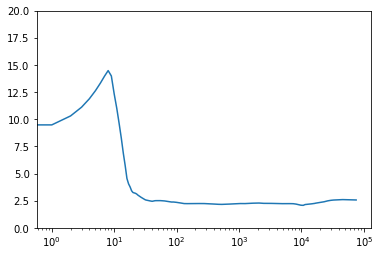

In [88]:
a=pd.DataFrame(
plt.plot(a[0],a[1])
plt.xscale('log')
plt.ylim(0,20)

(0.0, 20.0)

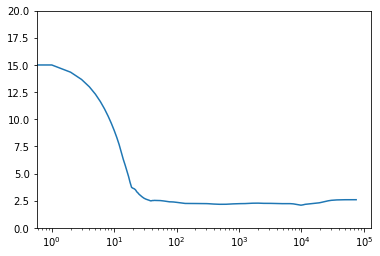

In [89]:
a=pd.DataFrame(sm.nonparametric.lowess(test.error.values,test['size'].values,frac=0.2)).drop_duplicates()
plt.plot(a[0],a[1])
plt.xscale('log')
plt.ylim(0,20)

(0.0, 20.0)

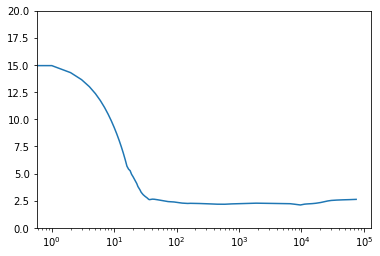

In [90]:
a=pd.DataFrame(sm.nonparametric.lowess(test.error.values,test['size'].values,frac=0.25)).drop_duplicates()
plt.plot(a[0],a[1])
plt.xscale('log')
plt.ylim(0,20)

(0.0, 20.0)

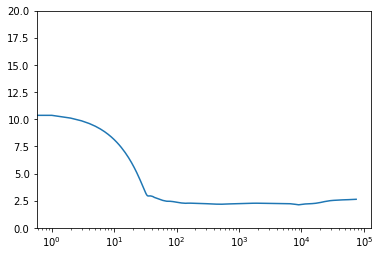

In [92]:
a=pd.DataFrame(sm.nonparametric.lowess(test.error.values,test['size'].values,frac=0.3)).drop_duplicates()
plt.plot(a[0],a[1])
plt.xscale('log')
plt.ylim(0,20)

(0.0, 20.0)

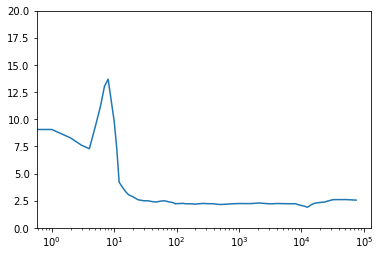

In [73]:
#plt.scatter(test['size'],test['error'])


In [ ]:
samples.replace(np.inf,1e4).describe()

,est_lb,est,est_ub,size,error
count,69000.000000,69000.000000,69000.000000,69000.000000,69000.000000
mean,14.640681,14.687015,14.733350,5689.163055,31.312985
std,2.174322,2.175798,2.177284,11657.876467,2.175798
min,12.381702,12.422389,12.463075,0.000000,25.856673
25%,12.879930,12.922374,12.965128,16.000000,30.990343
50%,13.982536,14.028592,14.074647,663.000000,31.971408
75%,14.954046,15.009657,15.065268,10000.000000,33.077626
max,19.983902,20.143327,20.302752,131072.000000,33.577611


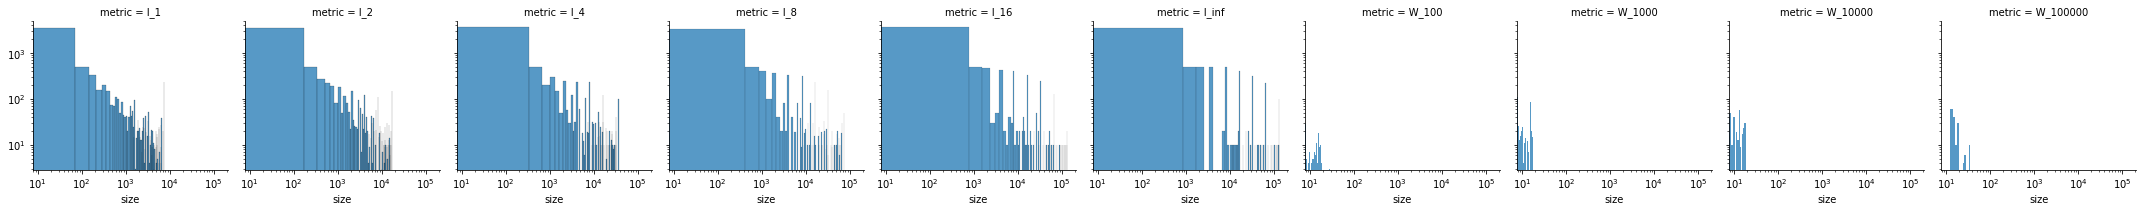

In [ ]:
g=sns.FacetGrid(samples.replace(np.inf,np.nan).dropna(axis=0),col='metric')
g.map(sns.histplot,'size')
plt.xscale('log')
plt.yscale('log')

Errors are completely wrong. need to redo

In [ ]:
ucl=pd.read_csv('../data/ucl_exact.csv')


In [ ]:
x=ucl[~ucl.height.isna()]
x.loc[:,'SS']=x.loc[:,'SS'].replace(np.nan,10)

In [ ]:
gm.algo.fit_edge(x.height.values,x.SS.values)

(14.70832000468112, 14.762473859945986, 14.816627715210853)

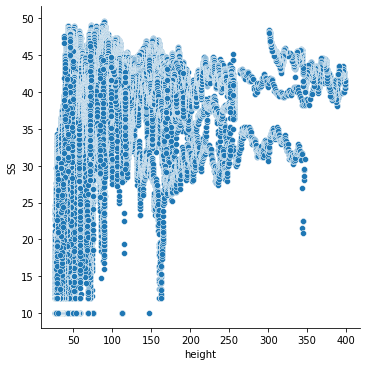

In [ ]:
sns.relplot(x='height',y='SS',data=x)

array([ 0.8,  0.1, 20. ,  0.2])

In [ ]:

model.fit_offline(x.height.values,x.SS.values,lik=False)[-1]

array([39.84001794,  0.37120691, 40.56569749, 13.56185205])

In [ ]:
samples